In [ ]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost, shap


In [ ]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# @title Load in 72 hour forecasts & ERA5 truth
# @markdown This will load in the ERA5 data and the AIWP data for the 72 hour lead time.
# @markdown The ERA5 data is the geopotential height at 500 hPa, and the AIWP data is the AIWP at the same level.

drive_data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"
drive_plot_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/"

df =pd.read_pickle(drive_data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

lead_times=[72]


for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(drive_data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight","keisler"])
    # df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    df = df.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
df.head()

72
Shape of df :(1556480, 9)


,time,longitude,latitude,era5,area_weight,graphcast,pangu,neuralgcm,ifshres
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN


In [ ]:
# @title Filter for subset of data: Timeframe (2020-01-04 to 2021-01-04)

df_filtered = df[(df['time'] > '2020-01-04') & (df['time'] < '2021-01-04')]

print(f"df_filtered: {df_filtered.shape}")
df_filtered.head()

df_filtered: (1497088, 9)


,time,longitude,latitude,era5,area_weight,graphcast,pangu,neuralgcm,ifshres
14336,2020-01-04 12:00:00,0.0,-87.1875,50107.359375,0.049068,50021.562500,49925.054688,50081.550781,50105.789062
14337,2020-01-04 12:00:00,0.0,-81.5625,50161.546875,0.146730,50143.582031,50095.757812,50177.425781,50220.472656
14338,2020-01-04 12:00:00,0.0,-75.9375,50108.054688,0.242980,50099.382812,50014.726562,50109.554688,50148.429688
14339,2020-01-04 12:00:00,0.0,-70.3125,49919.265625,0.336890,49886.250000,49772.355469,49815.640625,49886.316406
14340,2020-01-04 12:00:00,0.0,-64.6875,49165.363281,0.427555,49110.785156,49001.562500,49110.273438,49137.992188


In [ ]:
# @title Check for NaN values
# @markdown This will check for NaN values in the filtered dataframe.
df_filtered.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast,0
pangu,0
neuralgcm,0
ifshres,0


In [ ]:
# @title Define X, y, and area_weight
X = df_filtered[["graphcast", "pangu", "neuralgcm","ifshres", "longitude", "latitude"]]
y = df_filtered["era5"]
area_weight = df_filtered["area_weight"]

In [ ]:
print(f"Shape of x :{X.shape}")
print(f"Shape of y : {y.shape}")

Shape of x :(1497088, 6)
Shape of y : (1497088,)


### Calculate Cross-Validation error using 10 folds
(note that no hyperparameter tuning is done - we choose to stick with the xgboost defaults since they are known to work well out-of-the-box)

Note that the current version of SciPy, expects NumPy to be between versions 1.21.6 and 1.28.0.

In [ ]:
# @title Define Cross-Validation Strategy
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60, test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

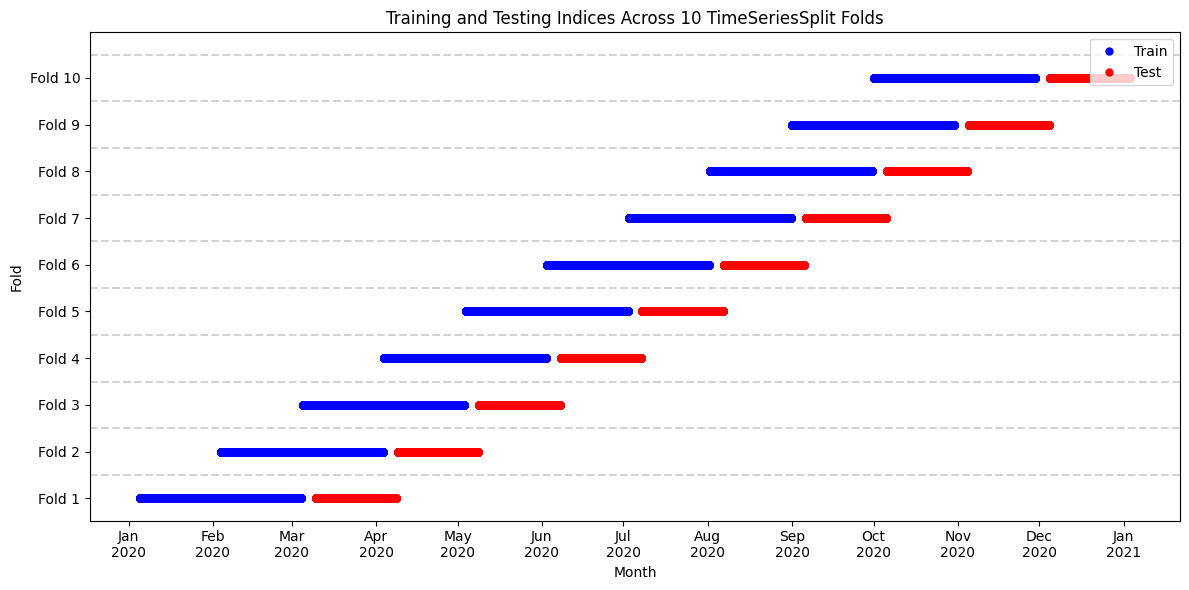

In [ ]:
# @title # Plot the train-test splits for each Fold

import matplotlib.dates as mdates

# Extract datetime info using the filtered df
time_index = df_filtered["time"].reset_index(drop=True)

# Store train/test index lists
train_indices_list = []
test_indices_list = []
for train_index, test_index in cv_timeseries.split(X):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Wider for clarity

# Plot each fold
for i in range(10):
    # Convert indices to datetime for x-axis
    train_times = time_index.iloc[train_indices_list[i]]
    test_times = time_index.iloc[test_indices_list[i]]

    ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
    ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
    ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

# Format x-axis as months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Fold')
ax.set_yticks(range(1, 11))
ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
ax.set_title('Training and Testing Indices Across 10 TimeSeriesSplit Folds')
ax.legend(loc='upper right')

# Improve layout and save
plt.tight_layout()
# plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/Training_Testing_Folds_By_Month.pdf',
#             dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
fold_ranges = []

for i, (train_idx, test_idx) in enumerate(zip(train_indices_list, test_indices_list)):
    train_times = time_index.iloc[train_idx]
    test_times = time_index.iloc[test_idx]

    fold_info = {
        "Fold": f"Fold {i+1}",
        "Train Start": train_times.min().strftime('%Y-%m-%d'),
        "Train End": train_times.max().strftime('%Y-%m-%d'),
        "Gap Start": (train_times.max() + pd.Timedelta(hours=12)).strftime('%Y-%m-%d'),
        "Gap End": (test_times.min() - pd.Timedelta(hours=12)).strftime('%Y-%m-%d'),
        "Test Start": test_times.min().strftime('%Y-%m-%d'),
        "Test End": test_times.max().strftime('%Y-%m-%d'),
    }
    fold_ranges.append(fold_info)

fold_ranges_df = pd.DataFrame(fold_ranges)
print(fold_ranges_df)


      Fold Train Start   Train End   Gap Start     Gap End  Test Start  \
0   Fold 1  2020-01-05  2020-03-04  2020-03-05  2020-03-09  2020-03-10   
1   Fold 2  2020-02-04  2020-04-03  2020-04-04  2020-04-08  2020-04-09   
2   Fold 3  2020-03-05  2020-05-03  2020-05-04  2020-05-08  2020-05-09   
3   Fold 4  2020-04-04  2020-06-02  2020-06-03  2020-06-07  2020-06-08   
4   Fold 5  2020-05-04  2020-07-02  2020-07-03  2020-07-07  2020-07-08   
5   Fold 6  2020-06-03  2020-08-01  2020-08-02  2020-08-06  2020-08-07   
6   Fold 7  2020-07-03  2020-08-31  2020-09-01  2020-09-05  2020-09-06   
7   Fold 8  2020-08-02  2020-09-30  2020-10-01  2020-10-05  2020-10-06   
8   Fold 9  2020-09-01  2020-10-30  2020-10-31  2020-11-04  2020-11-05   
9  Fold 10  2020-10-01  2020-11-29  2020-11-30  2020-12-04  2020-12-05   

     Test End  
0  2020-04-08  
1  2020-05-08  
2  2020-06-07  
3  2020-07-07  
4  2020-08-06  
5  2020-09-05  
6  2020-10-05  
7  2020-11-04  
8  2020-12-04  
9  2021-01-03  


In [ ]:
# @title Train XGBoost Model with Nested Cross-Validation
# @markdown This will train an XGBoost model using nested cross-validation with the defined time series split.
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )

nested_score

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:55:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'fit_time': array([0.95060039, 0.43246388, 0.42929196, 0.43599892, 0.42166448,
        0.47873282, 0.65954185, 1.60496092, 1.50176024, 1.20231843]),
 'score_time': array([0.06346011, 0.02098179, 0.02194953, 0.02063394, 0.0369277 ,
        0.04161716, 0.04431891, 0.14073467, 0.10231423, 0.05352807]),
 'test_neg_mean_squared_error': array([-25877.22265625, -20881.48046875, -16885.56835938, -21867.5078125 ,
        -18708.27148438, -17659.58203125, -15610.65136719, -15285.71289062,
        -12898.64941406, -11327.11132812]),
 'test_r2': array([0.99801332, 0.99813747, 0.99848485, 0.9979502 , 0.99839389,
        0.99833614, 0.99869239, 0.99881279, 0.99891502, 0.99892527])}

Fold 1:
  mse: 25877.22265625
  PiggyCast: area weighted rmse: 115.03192565675418
  graphcast area weighted rmse: 122.85387708812033
  pangu area weighted rmse: 135.08533958019098
  neuralgcm area weighted rmse: 108.71967205337731
  ifshres area weighted rmse: 131.52903243672063


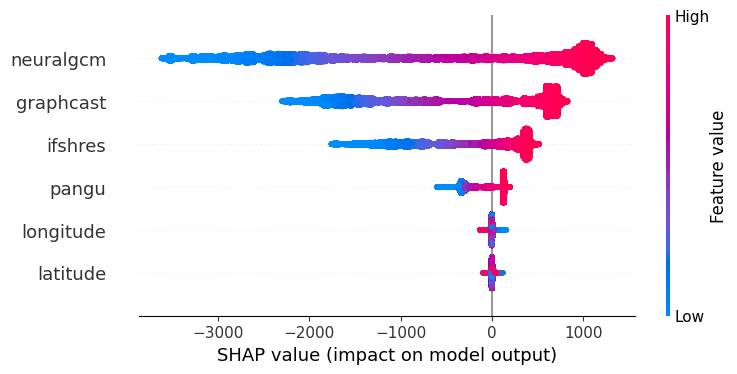

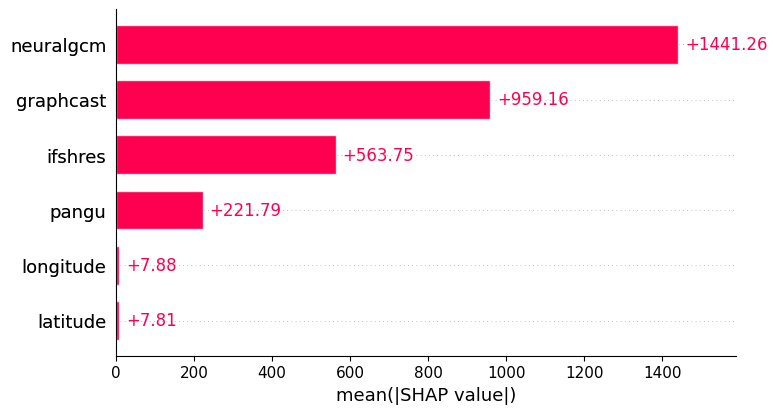

Fold 2:
  mse: 20881.48046875
  PiggyCast: area weighted rmse: 107.9994745127202
  graphcast area weighted rmse: 121.55502280923785
  pangu area weighted rmse: 134.301915560045
  neuralgcm area weighted rmse: 110.53258883735597
  ifshres area weighted rmse: 130.6921929942073


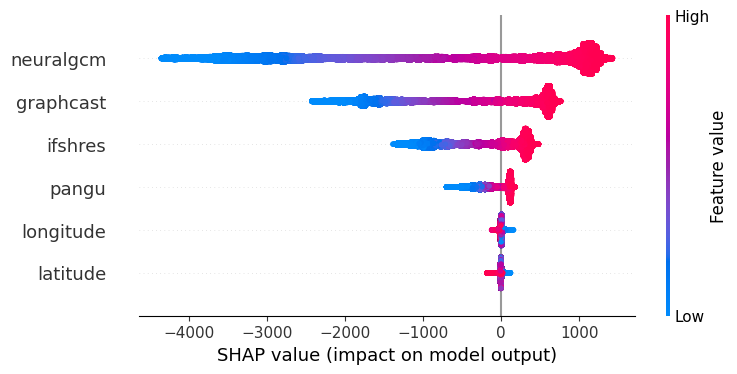

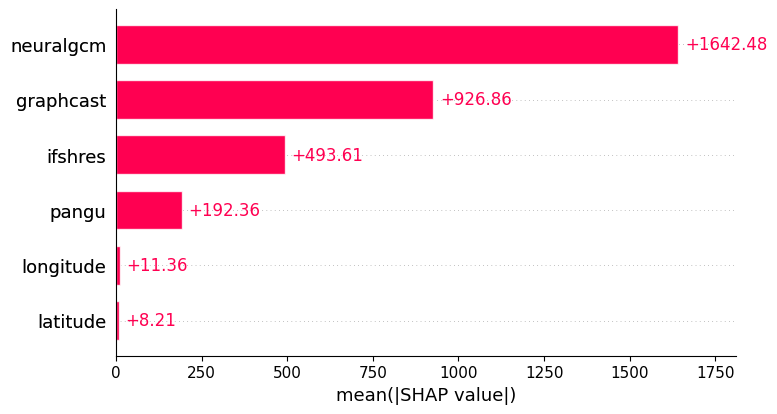

Fold 3:
  mse: 16885.568359375
  PiggyCast: area weighted rmse: 102.35013330448703
  graphcast area weighted rmse: 115.12777744553853
  pangu area weighted rmse: 124.96075061143948
  neuralgcm area weighted rmse: 106.80123183454789
  ifshres area weighted rmse: 126.64768147865912


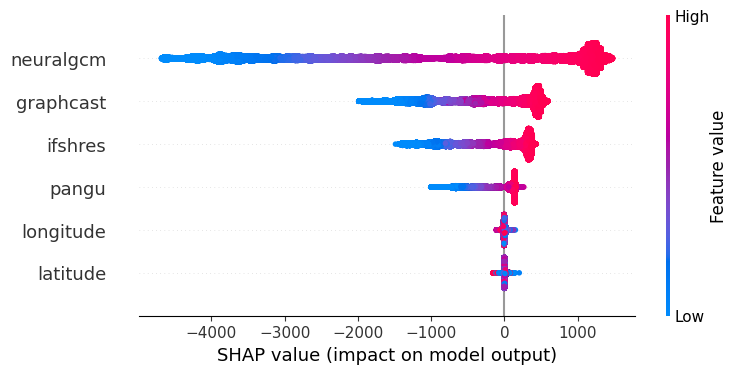

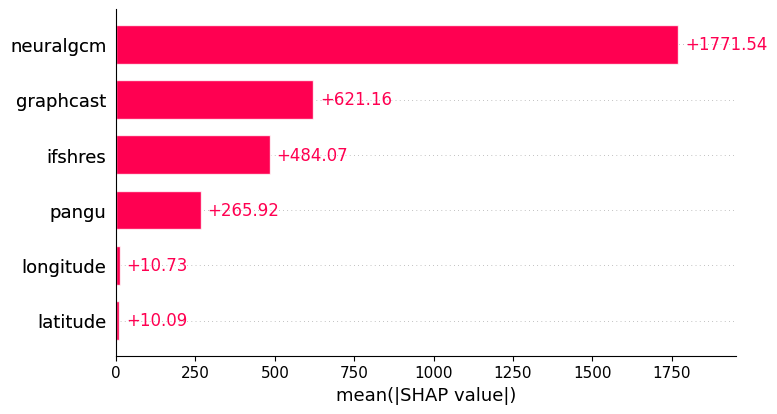

Fold 4:
  mse: 21867.5078125
  PiggyCast: area weighted rmse: 110.57140621198165
  graphcast area weighted rmse: 113.60324813116003
  pangu area weighted rmse: 129.28144312804812
  neuralgcm area weighted rmse: 110.34336069680998
  ifshres area weighted rmse: 125.42401589340629


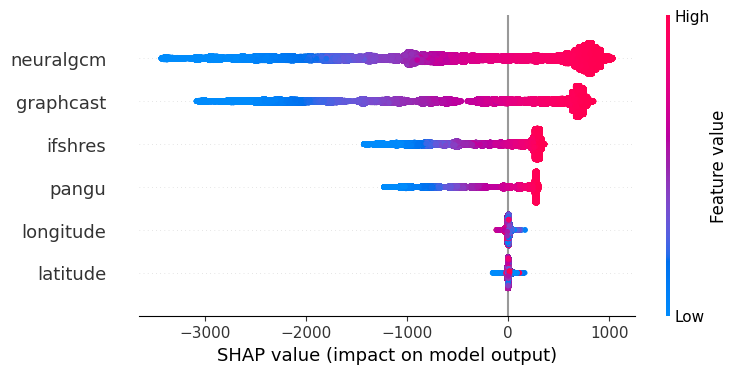

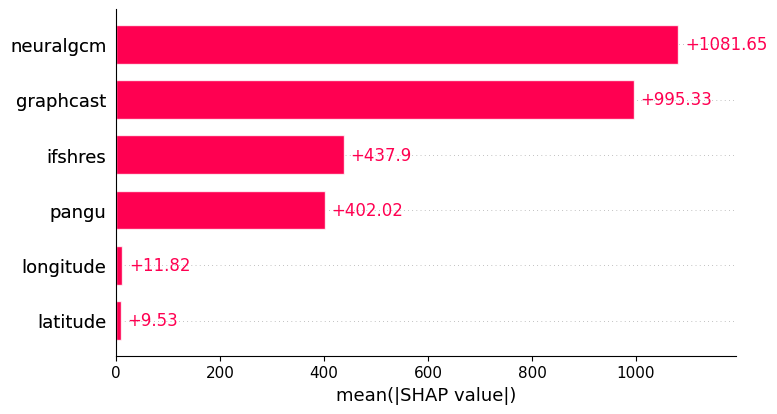

Fold 5:
  mse: 18708.271484375
  PiggyCast: area weighted rmse: 104.24449889316989
  graphcast area weighted rmse: 115.66416448280997
  pangu area weighted rmse: 125.03452254381654
  neuralgcm area weighted rmse: 108.10566962476716
  ifshres area weighted rmse: 122.3795501326147


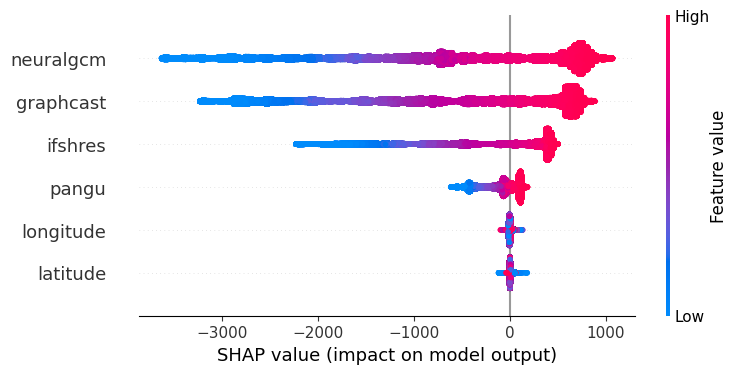

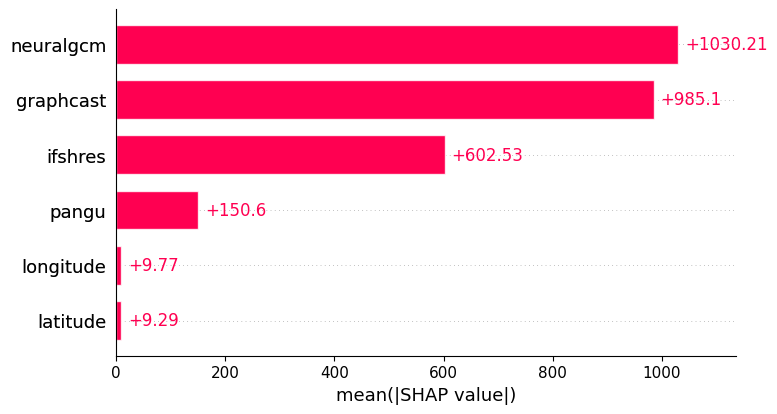

Fold 6:
  mse: 17659.58203125
  PiggyCast: area weighted rmse: 101.2720790290131
  graphcast area weighted rmse: 117.44068804253459
  pangu area weighted rmse: 132.0256062399261
  neuralgcm area weighted rmse: 104.11459238207713
  ifshres area weighted rmse: 127.61044134903098


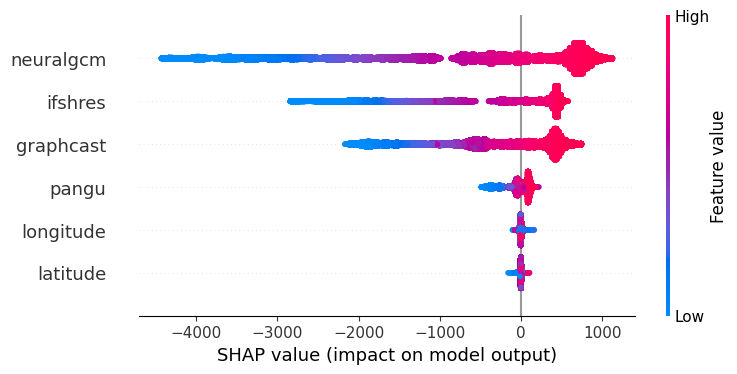

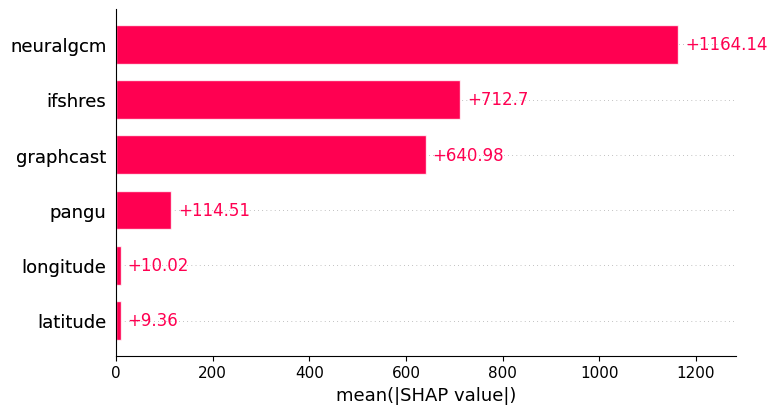

Fold 7:
  mse: 15610.6513671875
  PiggyCast: area weighted rmse: 97.68201533586064
  graphcast area weighted rmse: 116.53001874603304
  pangu area weighted rmse: 121.32061802132586
  neuralgcm area weighted rmse: 101.42341400176115
  ifshres area weighted rmse: 127.72751122938766


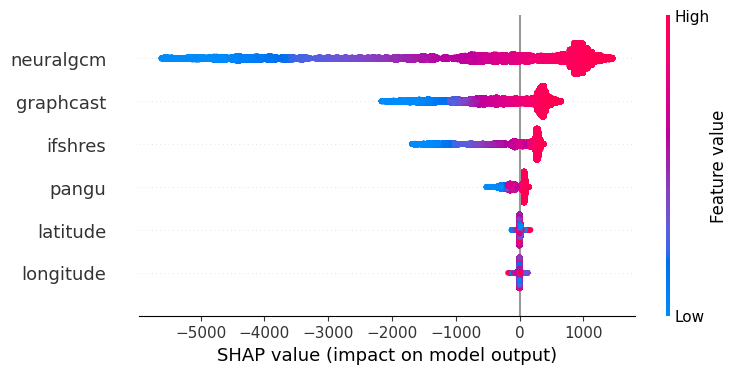

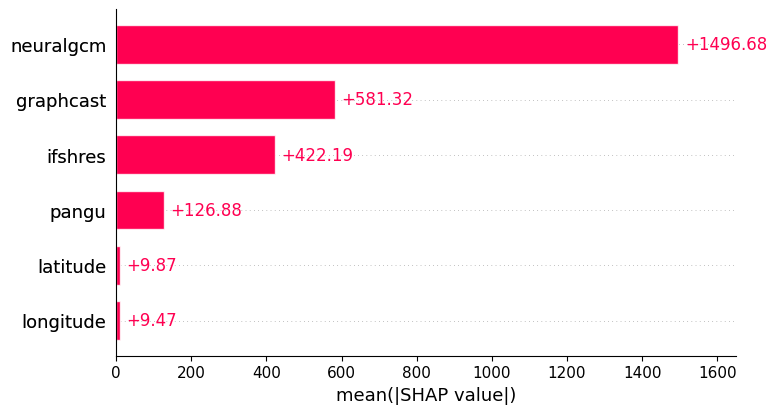

Fold 8:
  mse: 15285.712890625
  PiggyCast: area weighted rmse: 98.67804953989219
  graphcast area weighted rmse: 112.3207310966977
  pangu area weighted rmse: 119.82630686565231
  neuralgcm area weighted rmse: 103.73943264669145
  ifshres area weighted rmse: 121.25760167335962


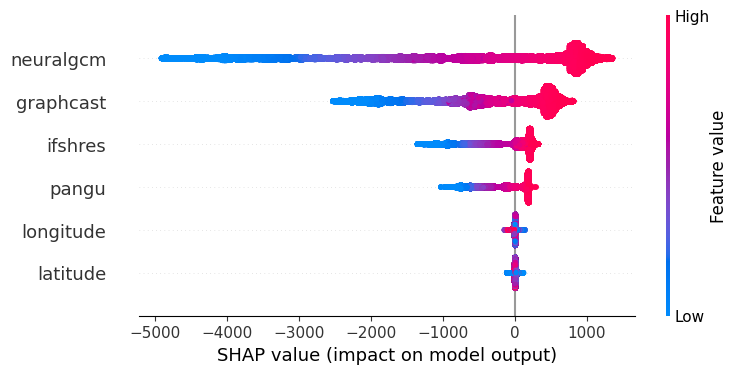

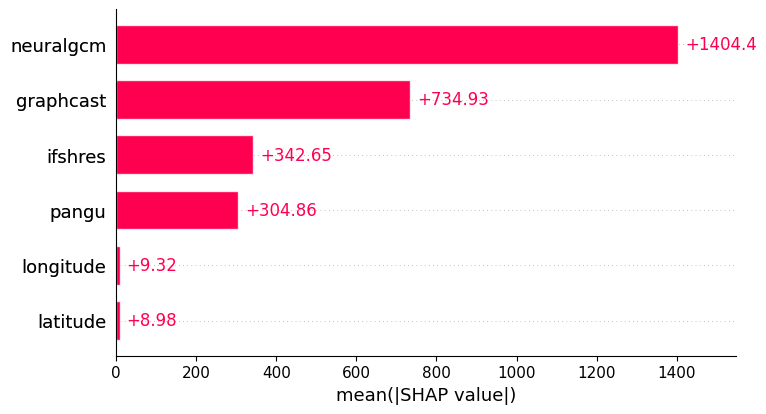

Fold 9:
  mse: 12898.6494140625
  PiggyCast: area weighted rmse: 92.67367861933877
  graphcast area weighted rmse: 109.83704338844261
  pangu area weighted rmse: 118.85577805793842
  neuralgcm area weighted rmse: 101.02463450734321
  ifshres area weighted rmse: 120.57419944017212


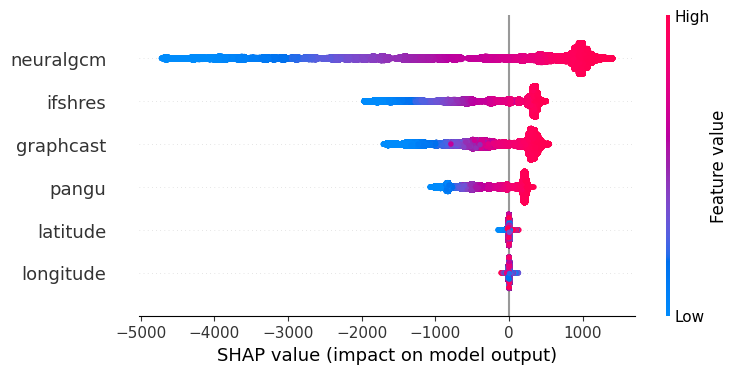

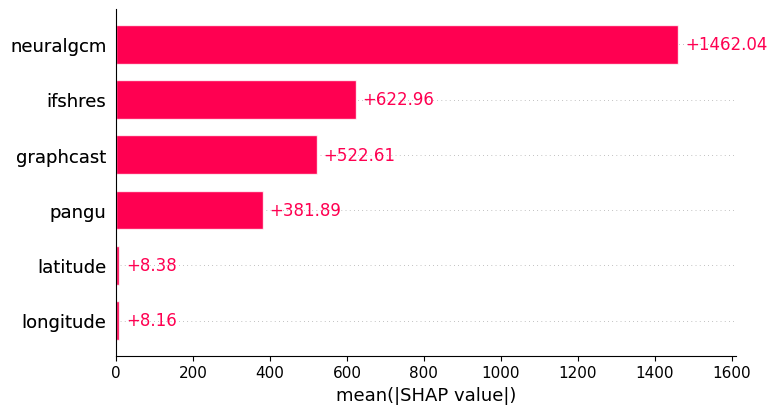

Fold 10:
  mse: 11327.111328125
  PiggyCast: area weighted rmse: 89.4399949907235
  graphcast area weighted rmse: 109.94350674268277
  pangu area weighted rmse: 117.66422571551385
  neuralgcm area weighted rmse: 96.27359312225816
  ifshres area weighted rmse: 116.08151803049746


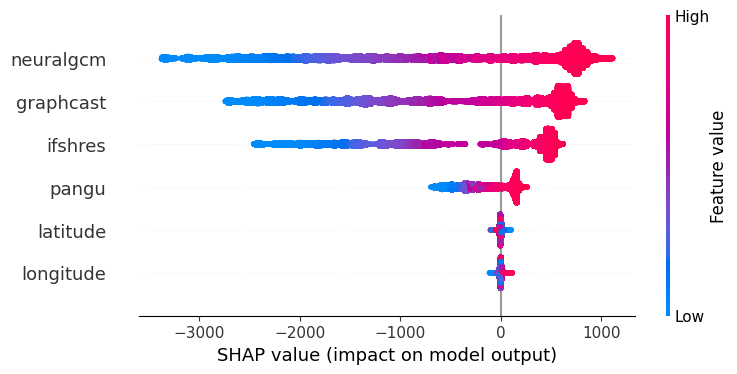

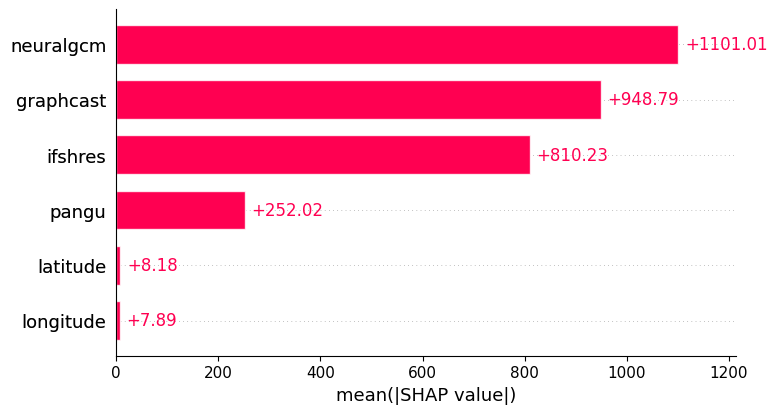

In [ ]:
# @title # RMSE Comparison for each model and fold
results = {}
shap_values = {}
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

for fold, (train_index, test_index) in enumerate(cv_timeseries.split(X)):
    print(f"Fold {fold+1}:")
    fold_results = {}

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])

    y_pred = xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"  mse: {mse}")

    area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
    print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
    fold_results["PiggyCast"] = area_weighted_rmse

    for model in ["graphcast", "pangu", "neuralgcm","ifshres"]:
        area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
        print(f"  {model} area weighted rmse: {area_weighted_rmse}")
        fold_results[model] = area_weighted_rmse

    results[fold+1] = fold_results


    explainer = shap.TreeExplainer(model=xgb)
    shap_values_fold = explainer(X_train)
    shap_values[fold+1] = shap_values_fold

    shap.plots.beeswarm(shap_values_fold)
    # plt.savefig(drive_plot_path+ f'shap_beeswarm_plot_at_{lead_time}_hr_lead_time.pdf', dpi=300, bbox_inches="tight")

    shap.plots.bar(shap_values_fold, max_display=12)
    # plt.savefig('/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/shap_bar_plot.png', dpi=300, bbox_inches="tight")



In [ ]:
# Confirming if the order of feature names is preserved across folds.
for fold, expl in shap_values.items():
    print(f"Fold {fold}: feature names = {expl.feature_names}")


Fold 1: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 2: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 3: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 4: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 5: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 6: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 7: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 8: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 9: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']
Fold 10: feature names = ['graphcast', 'pangu', 'neuralgcm', 'ifshres', 'longitude', 'latitude']


In [ ]:
# Since the shapley base value rely on the mean of the y_train used, then we should
# have 10 different means for each fold

for fold, shap_val in shap_values.items():
    print(f"Fold {fold} base value:", np.unique(shap_val.base_values))


Fold 1 base value: [55467.375]
Fold 2 base value: [55494.902]
Fold 3 base value: [55546.484]
Fold 4 base value: [55676.586]
Fold 5 base value: [55815.215]
Fold 6 base value: [55912.465]
Fold 7 base value: [55925.3]
Fold 8 base value: [55841.31]
Fold 9 base value: [55690.895]
Fold 10 base value: [55545.992]


In [ ]:
#
for fold, shap_val in shap_values.items():
    print(f"Fold {fold} data shape:", shap_val.values.shape)

Fold 1 data shape: (245760, 6)
Fold 2 data shape: (245760, 6)
Fold 3 data shape: (245760, 6)
Fold 4 data shape: (245760, 6)
Fold 5 data shape: (245760, 6)
Fold 6 data shape: (245760, 6)
Fold 7 data shape: (245760, 6)
Fold 8 data shape: (245760, 6)
Fold 9 data shape: (245760, 6)
Fold 10 data shape: (245760, 6)


In [ ]:
# Step 1: Collect all Explanation objects
all_explanations = list(shap_values.values())  # shap_values is your fold-wise dict

# Step 2: Concatenate .values, .base_values, .data, etc.
combined_values = np.concatenate([e.values for e in all_explanations], axis=0)
combined_base_values = np.concatenate([e.base_values for e in all_explanations], axis=0)
combined_data = np.concatenate([e.data for e in all_explanations], axis=0)

# Step 3: Recreate the Explanation object
combined_explanation = shap.Explanation(
    values=combined_values,
    base_values=combined_base_values,
    data=combined_data,
    feature_names=all_explanations[0].feature_names
)


In [ ]:
combined_explanation

.values =
array([[-1.6884929e+03, -3.4493890e+02, -2.4691719e+03, -1.0543159e+03,
        -1.1165463e+00, -2.2084921e+01],
       [-1.7067444e+03, -3.2701779e+02, -2.4888738e+03, -1.0422723e+03,
         6.2185435e+00, -1.9224512e+01],
       [-1.6695334e+03, -3.3077643e+02, -2.4415862e+03, -1.0661300e+03,
         4.6155529e+00, -2.1069670e+01],
       ...,
       [-1.9670728e+03, -4.8734467e+02, -2.1567751e+03, -1.5622285e+03,
         1.8657375e+01,  1.6095533e+00],
       [-2.2236506e+03, -4.7196942e+02, -2.2929138e+03, -1.6756273e+03,
         4.0175938e+01,  1.2320045e+00],
       [-2.2352185e+03, -4.7265796e+02, -2.2833760e+03, -1.7611923e+03,
         2.8512112e+01, -3.0052326e+01]], dtype=float32)

.base_values =
array([55467.375, 55467.375, 55467.375, ..., 55545.992, 55545.992,
       55545.992], dtype=float32)

.data =
array([[49888.203125  , 49812.09375   , 49980.234375  , 49953.        ,
            0.        ,   -87.1875    ],
       [49893.60546875, 49949.78125   , 49944

In [ ]:
combined_explanation.values.shape

(2457600, 6)

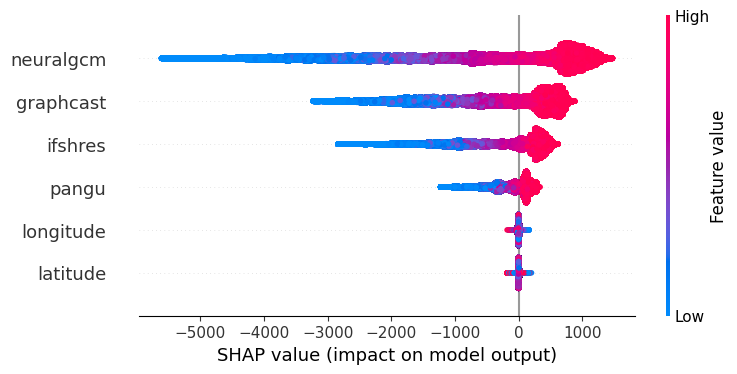

In [ ]:
shap.plots.beeswarm(combined_explanation)


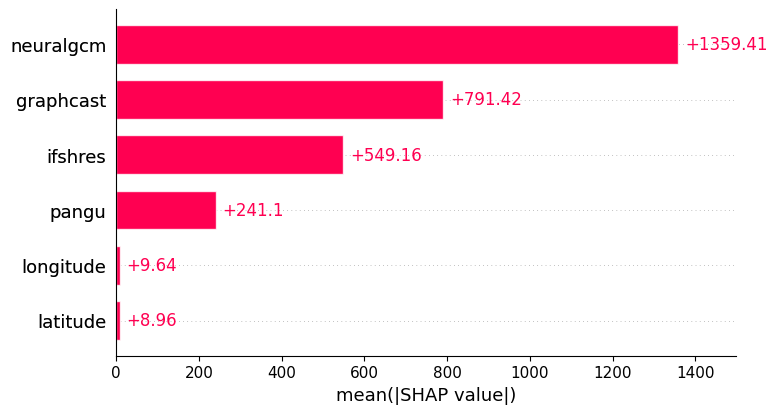

In [ ]:
shap.plots.bar(combined_explanation, max_display=12)


[ 791.6233    241.28403  1359.5413    549.2597      9.641648    8.97049 ]


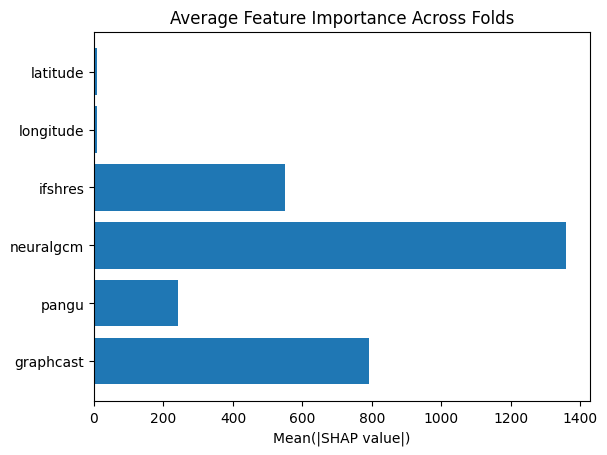

In [ ]:
# Step 1: Compute mean(|SHAP|) per feature per fold
fold_importances = [np.abs(e.values).mean(axis=0) for e in all_explanations]

# Step 2: Average across folds
avg_importance = np.mean(fold_importances, axis=0)
print(avg_importance)

# Step 3: Plot manually
import matplotlib.pyplot as plt

features = all_explanations[0].feature_names
plt.barh(features, avg_importance)
plt.xlabel("Mean(|SHAP value|)")
plt.title("Average Feature Importance Across Folds")
plt.show()


In [ ]:
import numpy as np

fold_importances = [np.abs(e.values).mean(axis=0) for e in all_explanations]
fold_importances = np.array(fold_importances)

# Compute standard deviation across folds for each feature
feature_std = fold_importances.std(axis=0)

for name, std in zip(all_explanations[0].feature_names, feature_std):
    print(f"{name} std across folds: {std:.2f}")


graphcast std across folds: 179.32
pangu std across folds: 95.14
neuralgcm std across folds: 240.52
ifshres std across folds: 134.86
longitude std across folds: 1.32
latitude std across folds: 0.74


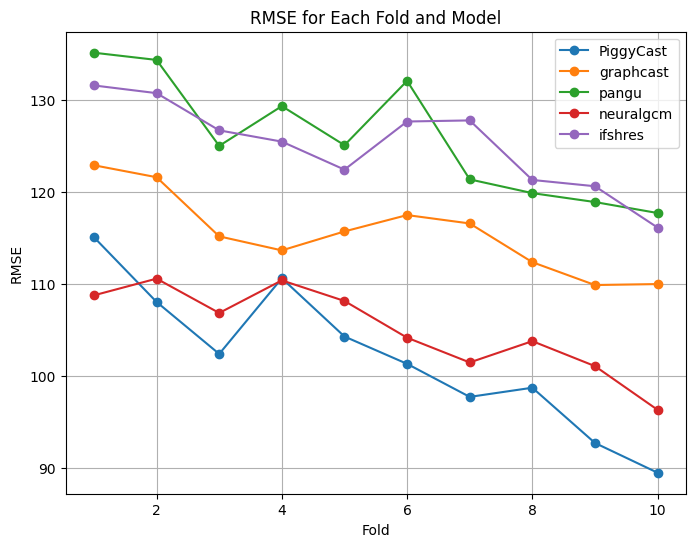

In [ ]:
# @title RMSE for each fold and model
fig, ax = plt.subplots(figsize=(8, 6))
  plt.rcParams['axes.titlesize'] = 16
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 14
  plt.rcParams['ytick.labelsize'] = 14
  plt.rcParams['legend.fontsize'] = 14

for model in results[1].keys():  # Iterate through all model names
    rmse_values = [results[fold][model] for fold in results]
    fold_numbers = list(results.keys())
    ax.plot(fold_numbers, rmse_values, label=model, marker='o')

ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for Each Fold and Model')
ax.legend(loc="upper right")
plt.grid(True)
plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/RMSE for Each Fold and Model.pdf', dpi=300, bbox_inches="tight")

plt.show()
